# Поиск изображения по контенту

In [38]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Дескриптор изображения

In [20]:
class ColorDescriptor:
    def __init__(self, bins):
        # store the number of bins for the 3D histogram
        self.bins = bins
 
    def describe(self, image):
        # convert the image to the HSV color space and initialize
        # the features used to quantify the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        features = []
 
        # grab the dimensions and compute the center of the image
        (h, w) = image.shape[:2]
        (cX, cY) = (int(w * 0.5), int(h * 0.5))
        
        # divide the image into four rectangles/segments (top-left,
        # top-right, bottom-right, bottom-left)
        segments = [(0, cX, 0, cY), (cX, w, 0, cY), (cX, w, cY, h),
            (0, cX, cY, h)]
 
        # construct an elliptical mask representing the center of the
        # image
        (axesX, axesY) = (int(w * 0.75) // 2, int(h * 0.75) // 2)
        ellipMask = np.zeros(image.shape[:2], dtype = "uint8")
        cv2.ellipse(ellipMask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)
 
        # loop over the segments
        for (startX, endX, startY, endY) in segments:
            # construct a mask for each corner of the image, subtracting
            # the elliptical center from it
            cornerMask = np.zeros(image.shape[:2], dtype = "uint8")
            cv2.rectangle(cornerMask, (startX, startY), (endX, endY), 255, -1)
            cornerMask = cv2.subtract(cornerMask, ellipMask)
 
            # extract a color histogram from the image, then update the
            # feature vector
            hist = self.histogram(image, cornerMask)
            features.extend(hist)
 
        # extract a color histogram from the elliptical region and
        # update the feature vector
        hist = self.histogram(image, ellipMask)
        features.extend(hist)
 
        # return the feature vector
        return features
    
    def histogram(self, image, mask):
        # extract a 3D color histogram from the masked region of the
        # image, using the supplied number of bins per channel; then
        # normalize the histogram
        hist = cv2.calcHist([image], [0, 1, 2], mask, self.bins,
            [0, 180, 0, 256, 0, 256])
        hist = cv2.normalize(hist, np.zeros_like(hist)).flatten()
 
        # return the histogram
        return hist

## Вычисляем дескрипторы для базы изображений

In [25]:
import glob

index = []
index_features = []

cd = ColorDescriptor((8, 12, 3))

files = list(glob.glob('./data/inria/jpg/*.jpg'))


# use glob to grab the image paths and loop over them
for imagePath in files[:25]:
    # extract the image ID (i.e. the unique filename) from the image
    # path and load the image itself
    imageID = imagePath[imagePath.rfind("/") + 1:]
    image = cv2.imread(imagePath)
 
    # describe the image
    features = cd.describe(image)
    
    index.append(imageID)
    index_features.append(features)
    
index_features = np.array(index_features)

## Определяем меру расстояния между дескрипторами

In [60]:
def chi2_distance(histA, histB, eps = 1e-10):
    # мера расстояния chi-квадрат
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
                      for (a, b) in zip(histA, histB)])
    return d

In [67]:
def rank(query_features, index_features):
    # вычисляем расстояние до изображения из базы
    result = np.zeros(len(index_features))
    for i in range(len(index_features)):
        result[i] = chi2_distance(query_features, index_features[i])
    return result

## Формируем запрос и выводим похожие изображения

In [97]:
query = cv2.imread(files[3])

query_features = cd.describe(query)
distance = rank(query_features, index_features)

In [98]:
# сортируем индексы по расстоянию
indices = np.argsort(distance)

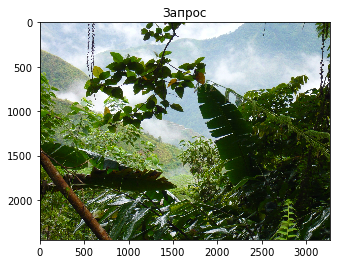

In [99]:
plt.imshow(cv2.cvtColor(query, cv2.COLOR_BGR2RGB))
plt.title('Запрос')

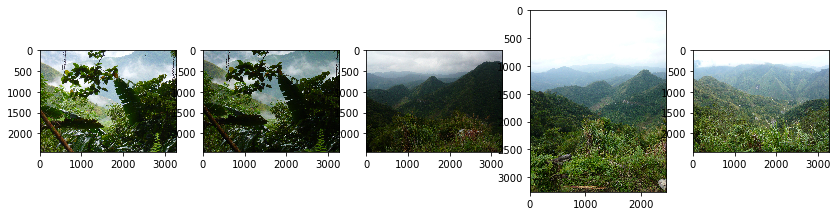

In [100]:
# Выводим топ 5 самых близких изображений
fig = plt.figure(figsize=(20, 10))
for i, idx in enumerate(indices[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    img = cv2.imread(files[idx])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))